In [ ]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# load dataset
dataset = pd.read_csv('time_series_solar-dataset.csv', header=0)


In [ ]:
dataset.tail()

,Time,irradiation_forecast,temp_forecast,irradiation,temperature,power
36715,10-03-21 19,19.610334,4.694629,0.770375,3.713455,0.0
36716,10-03-21 20,0.000000,3.454629,0.987695,2.694212,0.0
36717,10-03-21 21,0.000000,2.124629,0.987637,1.834956,0.0
36718,10-03-21 22,0.000000,1.034629,0.993837,1.209808,0.0
36719,10-03-21 23,0.000000,0.264629,0.987654,0.613663,0.0


In [ ]:
dataset.head()

,Time,irradiation_forecast,temp_forecast,irradiation,temperature,power
0,01-01-17 00,0.0,-2.115371,0.802334,0.720098,0.0
1,01-01-17 01,0.0,-2.185371,1.000000,1.154616,0.0
2,01-01-17 02,0.0,-2.265371,0.891393,1.304207,0.0
3,01-01-17 03,0.0,-2.445371,0.837256,1.079527,0.0
4,01-01-17 04,0.0,-2.845371,0.848814,0.649967,0.0


In [ ]:
dataset.set_index(pd.DatetimeIndex(dataset.Time),inplace=True)
dataset.drop(columns=['Time'],inplace=True)

In [ ]:
dataset.head()

,irradiation_forecast,temp_forecast,irradiation,temperature,power
Time,,,,,
2017-01-01 00:00:00,0.0,-2.115371,0.802334,0.720098,0.0
2017-01-01 01:00:00,0.0,-2.185371,1.000000,1.154616,0.0
2017-01-01 02:00:00,0.0,-2.265371,0.891393,1.304207,0.0
2017-01-01 03:00:00,0.0,-2.445371,0.837256,1.079527,0.0
2017-01-01 04:00:00,0.0,-2.845371,0.848814,0.649967,0.0


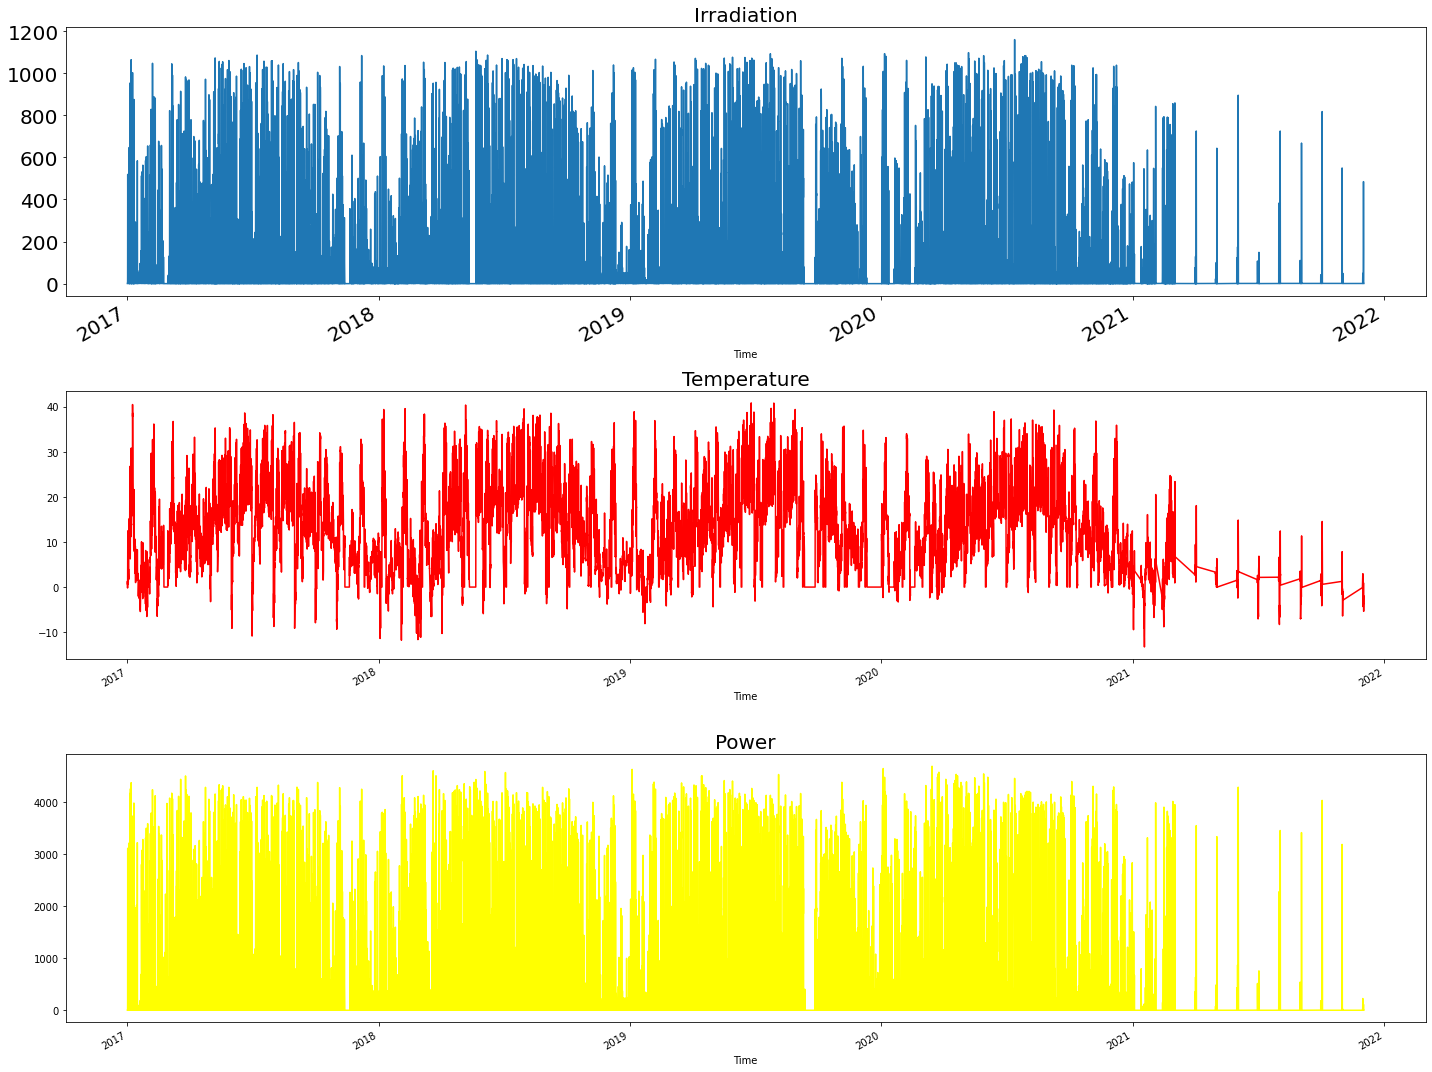

In [ ]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.title('Irradiation', fontsize=20)
dataset['irradiation'].plot(fontsize=20)
plt.subplot(3,1,2)
plt.title('Temperature', fontsize=20)
dataset['temperature'].plot(c='red')
plt.subplot(3,1,3)
plt.title('Power', fontsize=20)
dataset['power'].plot(c='yellow')
plt.tight_layout()

Coorelation

In [ ]:
dataset.corr()

,irradiation_forecast,temp_forecast,irradiation,temperature,power
irradiation_forecast,1.000000,0.485005,0.756643,0.540436,0.760658
temp_forecast,0.485005,1.000000,0.384108,0.900647,0.351192
irradiation,0.756643,0.384108,1.000000,0.570378,0.963415
temperature,0.540436,0.900647,0.570378,1.000000,0.505344
power,0.760658,0.351192,0.963415,0.505344,1.000000


Feature selection based on coorelation:

Target var: Power

Ind var: Irr_forecast, irradiation, forecast

**Linear regression model**

In [ ]:
X=dataset[['irradiation_forecast','temp_forecast','irradiation','temperature']]
Y=dataset[['power']]

In [ ]:
X=X.values
Y=Y.values
# ensure all data is float
X = X.astype('float32')
Y=Y.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X,Y)

In [ ]:
from sklearn import linear_model
lm=linear_model.LinearRegression()

In [ ]:
train_x=X[0:24*365*3]
train_y=Y[0:24*365*3]

test_x=X[24*365*3:24*365*4]
test_y=Y[24*365*3:24*365*4]

In [ ]:
lm.fit(train_x,train_y)
y_predict=lm.predict(test_x)

print('r2 score: ',metrics.r2_score(y_predict,test_y))
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_predict,test_y)))

r2 score:  0.9495209334219327
RMSE:  249.12837


**Lasso Model**

In [ ]:
reg = linear_model.Lasso(alpha=0.5)
reg.fit(train_x,train_y)
y_predict=reg.predict(test_x)
print('r2 score: ',metrics.r2_score(y_predict,test_y))
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_predict,test_y)))

r2 score:  0.9494789136363553
RMSE:  249.03334


**LSTM**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 3, 1)

In [ ]:
# drop columns we don't want to predict
reframed.drop(["var1(t)",'var2(t)','var3(t)',"var4(t)"], axis=1,inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 *3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var1(t-2)  \
3   0.010271   0.200948   0.000692   0.258640        0.0   0.010271   
4   0.010271   0.199505   0.000862   0.266671        0.0   0.010271   
5   0.010271   0.197857   0.000768   0.269436        0.0   0.010271   
6   0.010271   0.194147   0.000722   0.265284        0.0   0.010271   
7   0.010271   0.185903   0.000732   0.257344        0.0   0.010271   

   var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)  \
3   0.199505   0.000862   0.266671        0.0   0.010271   0.197857   
4   0.197857   0.000768   0.269436        0.0   0.010271   0.194147   
5   0.194147   0.000722   0.265284        0.0   0.010271   0.185903   
6   0.185903   0.000732   0.257344        0.0   0.010271   0.180132   
7   0.180132   0.000724   0.247427        0.0   0.010271   0.176010   

   var3(t-1)  var4(t-1)  var5(t-1)  var5(t)  
3   0.000768   0.269436        0.0      0.0  
4   0.000722   0.265284        0.0      0.0  
5   0.00

Epoch 1/50
365/365 - 4s - loss: 0.0601 - val_loss: 0.0506 - 4s/epoch - 10ms/step
Epoch 2/50
365/365 - 1s - loss: 0.0436 - val_loss: 0.0511 - 1s/epoch - 3ms/step
Epoch 3/50
365/365 - 1s - loss: 0.0419 - val_loss: 0.0496 - 1s/epoch - 3ms/step
Epoch 4/50
365/365 - 1s - loss: 0.0409 - val_loss: 0.0478 - 1s/epoch - 3ms/step
Epoch 5/50
365/365 - 1s - loss: 0.0404 - val_loss: 0.0479 - 1s/epoch - 3ms/step
Epoch 6/50
365/365 - 1s - loss: 0.0399 - val_loss: 0.0492 - 1s/epoch - 3ms/step
Epoch 7/50
365/365 - 1s - loss: 0.0397 - val_loss: 0.0494 - 1s/epoch - 4ms/step
Epoch 8/50
365/365 - 1s - loss: 0.0395 - val_loss: 0.0498 - 1s/epoch - 3ms/step
Epoch 9/50
365/365 - 1s - loss: 0.0391 - val_loss: 0.0487 - 1s/epoch - 3ms/step
Epoch 10/50
365/365 - 1s - loss: 0.0388 - val_loss: 0.0482 - 1s/epoch - 3ms/step
Epoch 11/50
365/365 - 1s - loss: 0.0385 - val_loss: 0.0468 - 1s/epoch - 3ms/step
Epoch 12/50
365/365 - 1s - loss: 0.0382 - val_loss: 0.0459 - 1s/epoch - 3ms/step
Epoch 13/50
365/365 - 1s - loss: 0.0

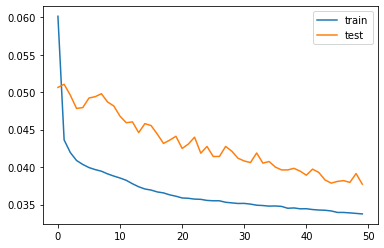

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
pr=model.predict(test_X)
print("RMSE: ",np.sqrt(metrics.mean_squared_error(pr,test_y)))
print("MAE: ",metrics.mean_absolute_error(pr,test_y))

RMSE:  0.080988005
MAE:  0.037723634


**Clustering**

In [ ]:
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 4.9 MB/s 


In [ ]:
from tslearn.metrics import dtw
dtw_score = dtw(x, y)

NameError: ignored

In [ ]:
from tslearn.metrics import soft_dtw
soft_dtw_score = soft_dtw(x, y, gamma=.1)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(dataset)

ValueError: ignored